# 🤖 Machine Learning Pipeline: Predicting Type 2 Diabetes (T2D) from Metabolomic Profiles

This notebook is Part 2 of a two-part analysis exploring metabolomic data associated with **Type 2 Diabetes (T2D)**. Building on the previous exploratory data analysis (EDA), this notebook implements a **machine learning (ML) pipeline** for classification using engineered and biologically annotated metabolite features.

---

## 🧰 Key Components

- **⚙️ Data Preparation**:  
  Preprocessing pipeline includes median imputation and standard scaling.

- **🔍 Feature Set**:  
  Input features are derived from curated metabolite measurements, with "Class" used as the binary T2D target label.

- **🧪 Model Training & Evaluation**:  
  A **logistic regression model with elastic net regularization** is trained using a nested cross-validation strategy:
  - Inner 3-fold Stratified CV for hyperparameter tuning (GridSearchCV).
  - Outer 3-fold Stratified CV for robust model evaluation.

- **📊 Performance Metrics**:  
  - Confusion matrix and classification report  
  - ROC AUC score  
  - ROC and Precision–Recall curves

- **🧠 Interpretability (Optional)**:  
  Includes SHAP value computation for post hoc model interpretation and feature importance analysis (if enabled).

---

## 📁 Dataset Summary

The dataset used (`ST001906_1.csv`) includes high-resolution metabolomic profiles labeled by T2D status. Each row represents a sample, and columns correspond to metabolite concentrations. The target variable is a binary label indicating disease presence.

---

## 🎯 Objective

To train and validate a predictive model for Type 2 Diabetes based on metabolomic data, while ensuring interpretability and generalizability using rigorous cross-validation. This work sets the stage for future development of diagnostic tools or biological hypothesis testing.

---

## 🧾 Credits and Notes

*This notebook continues from Part 1 (EDA) and assumes pre-existing knowledge of the dataset and its biological context. Please cite original sources when reusing data or referencing this pipeline.*

---

*Author: [Tomasz Lasota]*  
*Date: [2025-06-29]*

## Part 2: ML Pipeline

## 1. Settings and imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from pathlib import Path
import shap
import seaborn as sns
from tabulate import tabulate

In [19]:
class CF:

    def __init__(self):
        self.dataset = Path("ST001906_1.csv")

        if not self.dataset.exists():
            raise FileNotFoundError(f"Dataset {self.dataset} not found.")

In [20]:
df = pd.read_csv(CF().dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 80 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     61 non-null     object 
 1   Class                  61 non-null     int64  
 2   1,5-Anhydroglucitol    61 non-null     float64
 3   2-Aminobutyrate        61 non-null     float64
 4   2-Hydroxybutyrate      61 non-null     float64
 5   3-Aminoisobutyrate     61 non-null     float64
 6   3-Hydroxybutyrate      61 non-null     float64
 7   Alanine                61 non-null     float64
 8   Allose                 60 non-null     float64
 9   alpha-Tocopherol       61 non-null     float64
 10  Arabinose              61 non-null     float64
 11  Arginine               61 non-null     float64
 12  Asparagine             61 non-null     float64
 13  Aspartate              61 non-null     float64
 14  beta-Alanine           61 non-null     float64
 15  Choleste

## 2. Model Training and Evaluation

In [21]:
# Define target and features variables
y = df["Class"]
X = df.drop(columns=["Class", "ID"])

In [22]:
# Define the ML pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(penalty="elasticnet",
                                      solver="saga",
                                      max_iter=10000,))
])

# Define the hyperparameter grid
param_grid = {
    "classifier__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    "classifier__C": [0.01, 0.1, 1, 10],
}

In [23]:
# Define cross-validation strategy for hyperparamiter tuning and model evaluation

# Inner CV: For hyperparameter tuning using GridSearch
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Outer CV: For model evaluation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store all results
all_y_true = []
all_y_pred = []
all_y_prob = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Define GridSearchCV object
    grid_search = GridSearchCV(estimator=pipeline, 
                            param_grid=param_grid, 
                            cv=inner_cv, 
                            scoring="roc_auc", 
                            n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Save predictions
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)


In [24]:
# Final confusion matrix and classification report
cm = confusion_matrix(all_y_true, all_y_pred)
report_dict = classification_report(all_y_true, all_y_pred, output_dict=True, digits=3)
report = pd.DataFrame(report_dict).T
aucc = roc_auc_score(all_y_true, all_y_prob)

print("Confusion Matrix:\n", cm)
print(tabulate(report, headers="keys", tablefmt="pipe", floatfmt=".3f"))
print(f"Overall ROC AUC: {aucc:.3f}")

Confusion Matrix:
 [[26  4]
 [ 1 30]]
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |       0.963 |    0.867 |      0.912 |    30.000 |
| 1            |       0.882 |    0.968 |      0.923 |    31.000 |
| accuracy     |       0.918 |    0.918 |      0.918 |     0.918 |
| macro avg    |       0.923 |    0.917 |      0.918 |    61.000 |
| weighted avg |       0.922 |    0.918 |      0.918 |    61.000 |
Overall ROC AUC: 0.969


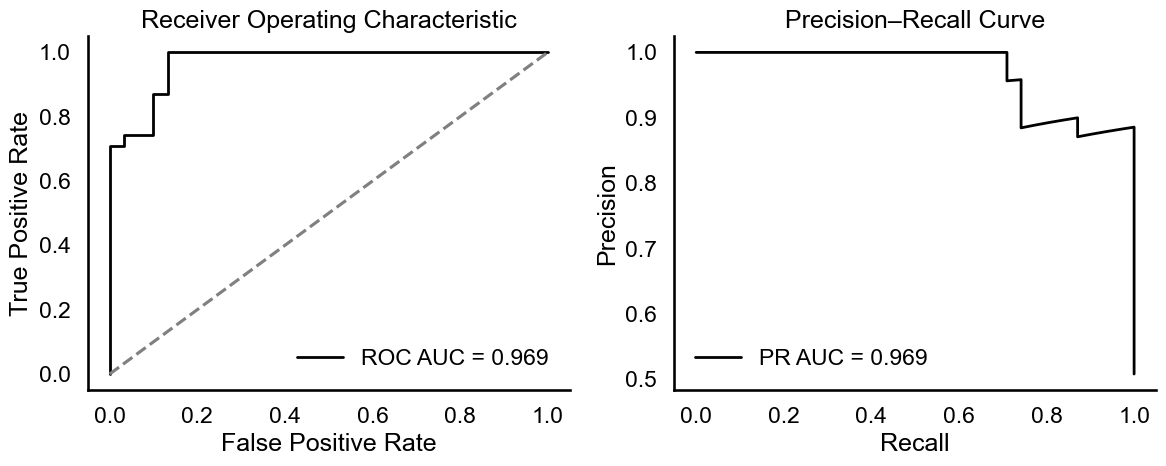

In [36]:
# Set black-and-white publication style
sns.set_theme(style="white", context="talk", rc={
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.labelcolor": "black",
    "text.color": "black",
    "axes.spines.top": False,
    "axes.spines.right": False
})
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# ROC Curve
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)

# PR Curve
precision, recall, _ = precision_recall_curve(all_y_true, all_y_prob)
pr_auc = auc(recall, precision)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- ROC Curve ---
axes[0].plot(fpr, tpr, linestyle='-', color='black', linewidth=2, label=f'ROC AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic')
axes[0].legend(loc="lower right", frameon=False)

# --- PR Curve ---
axes[1].plot(recall, precision, linestyle='-', color='black', linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision–Recall Curve')
axes[1].legend(loc="lower left", frameon=False)

plt.tight_layout()
plt.show()

In [26]:
# Compute feature importance 
best_C = grid_search.best_params_["classifier__C"]
best_l1 = grid_search.best_params_["classifier__l1_ratio"]

final_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(penalty="elasticnet",
                                      solver="saga",
                                      max_iter=10000,
                                      C=best_C,
                                      l1_ratio=best_l1))
])

final_pipeline.fit(X, y)

coefs = final_pipeline.named_steps["classifier"].coef_[0]
feature_names = X.columns

# Combine with feature names
coef_df = pd.DataFrame({
    'Metabolite': X.columns,
    'Coefficient': coefs,
    'AbsCoefficient': np.abs(coefs)
}).sort_values(by='AbsCoefficient', ascending=False)

print(coef_df.head(30))

               Metabolite  Coefficient  AbsCoefficient
0     1,5-Anhydroglucitol    -0.652669        0.652669
2       2-Hydroxybutyrate     0.444055        0.444055
24                Glucose     0.172936        0.172936
48                Mannose     0.151710        0.151710
6                  Allose     0.142079        0.142079
17                Cystine     0.116696        0.116696
1         2-Aminobutyrate     0.106194        0.106194
23              Gluconate     0.080646        0.080646
3      3-Aminoisobutyrate     0.028389        0.028389
36  Indole-3-acetaldehyde     0.025987        0.025987
22              Galactose     0.002845        0.002845
59              Phosphate     0.002683        0.002683
5                 Alanine     0.000000        0.000000
4       3-Hydroxybutyrate     0.000000        0.000000
13            Cholesterol     0.000000        0.000000
12           beta-Alanine     0.000000        0.000000
11              Aspartate     0.000000        0.000000
10        

In [27]:
# Permutaiton testing
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# True AUC
true_preds = []
true_labels = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    final_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(penalty="elasticnet",
                                      solver="saga",
                                      max_iter=10000,
                                      C=best_C,
                                      l1_ratio=best_l1)),
    ])

    final_pipeline.fit(X_train, y_train)
    y_prob = final_pipeline.predict_proba(X_test)[:, 1]
    true_preds.extend(y_prob)
    true_labels.extend(y_test)

true_auc = roc_auc_score(true_labels, true_preds)

# Permutation test
n_permutations = 1000
permuted_aucs = []

#Simulate a null model
for i in range(n_permutations):
    y_perm = np.random.permutation(y)
    perm_preds = []
    perm_labels = []

    for train_idx, test_idx in outer_cv.split(X, y_perm):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_perm[train_idx], y_perm[test_idx]

        final_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(penalty="elasticnet",
                                        solver="saga",
                                        max_iter=10000,
                                        C=best_C,
                                        l1_ratio=best_l1)),
        ])
        final_pipeline.fit(X_train, y_train)
        y_prob = final_pipeline.predict_proba(X_test)[:, 1]
        perm_preds.extend(y_prob)
        perm_labels.extend(y_test)

    auc = roc_auc_score(perm_labels, perm_preds)
    permuted_aucs.append(auc)

# Calculate p-value
permuted_aucs = np.array(permuted_aucs)
p_value = np.mean(permuted_aucs >= true_auc)

print(f"True AUC: {true_auc:.3f}")
print(f"Permutation p-value: {p_value:.4f}")

True AUC: 0.989
Permutation p-value: 0.0000


In [39]:
# Bootstrap AUC CI
"""
What it does:
Repeatedly samples with replacement from your dataset.
Fits the model and computes the AUC on each bootstrap sample.
After many iterations, gives a distribution of AUCs.
You can then compute, for example, a 95% CI of the AUC.

"""
n_bootstraps = 1000
rng = np.random.RandomState(42)
boot_aucs = []

for i in range(n_bootstraps):
    # Sample with replacement
    indices = rng.randint(0, len(X), len(X))
    oob_indices = np.setdiff1d(np.arange(len(X)), indices)

    X_boot = X.iloc[indices]
    y_boot = y.iloc[indices]
    
    # Make sure there are both classes in the bootstrap sample
    if len(np.unique(y_boot)) < 2 or len(oob_indices) == 0:
        continue

    # Fit pipeline on bootstrap sample
    final_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(penalty="elasticnet",
                                        solver="saga",
                                        max_iter=10000,
                                        C=best_C,
                                        l1_ratio=best_l1)),
        ])
    final_pipeline.fit(X_boot, y_boot)

    # Predict on out-of-bag (OOB) samples — optional but skipped here
    y_prob = final_pipeline.predict_proba(X.iloc[oob_indices])[:, 1]
    auc = roc_auc_score(y.iloc[oob_indices], y_prob)
    boot_aucs.append(auc)

boot_aucs = np.array(boot_aucs)

# Compute 95% CI
lower = np.percentile(boot_aucs, 2.5)
upper = np.percentile(boot_aucs, 97.5)

print(f"Bootstrapped AUC 95% CI: [{lower:.3f}, {upper:.3f}]")
print(f"Mean Bootstrapped AUC: {np.mean(boot_aucs):.3f}")

Bootstrapped AUC 95% CI: [0.875, 1.000]
Mean Bootstrapped AUC: 0.969


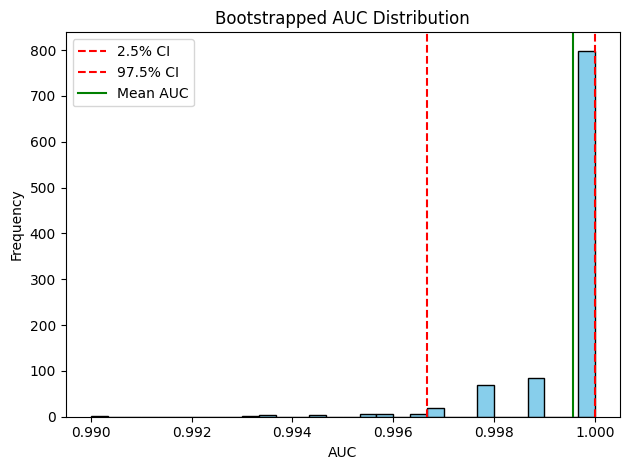

In [29]:
plt.hist(boot_aucs, bins=30, color='skyblue', edgecolor='black')
plt.axvline(lower, color='red', linestyle='--', label='2.5% CI')
plt.axvline(upper, color='red', linestyle='--', label='97.5% CI')
plt.axvline(np.mean(boot_aucs), color='green', linestyle='-', label='Mean AUC')
plt.title('Bootstrapped AUC Distribution')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Extract the scaler and the logistic regression model
scaler = final_pipeline.named_steps['scaler']
model = final_pipeline.named_steps["classifier"]

# Scale the data
X_scaled = scaler.transform(X)

# Initialize SHAP explainer for linear models
explainer = shap.LinearExplainer(model, X_scaled, feature_names=X.columns)

# Compute SHAP values for all samples
shap_values = explainer.shap_values(X_scaled)

c:\Users\tomla\Documents\Projects\Diabetes\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


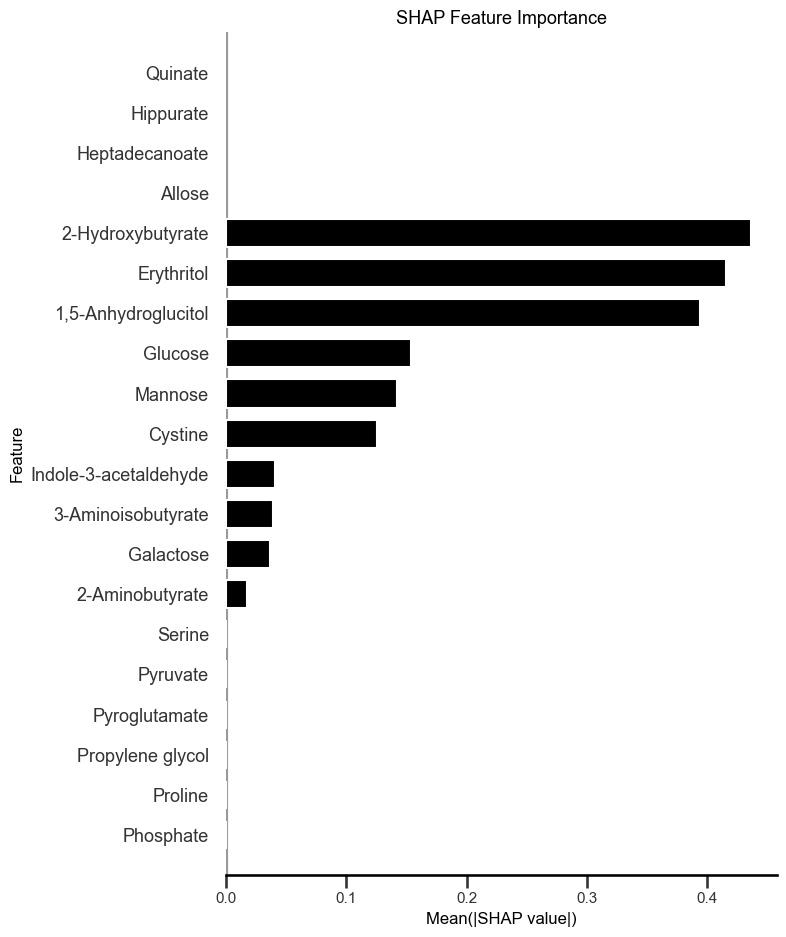

In [42]:
# Set black and white style manually
plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "grid.color": "lightgray",
    "text.color": "black",
    "font.size": 11
})

shap.summary_plot(
    shap_values,
    X_scaled,
    feature_names=X.columns,
    plot_type="bar",
    color="black",
    show=False
)

plt.title("SHAP Feature Importance", fontsize=13)
plt.xlabel("Mean(|SHAP value|)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()